Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
from sklearn.metrics import mean_absolute_error as mae
import time
import numpy as np

Loading the dataset

In [2]:
#reading the data and making the date is the index
data=pd.read_csv('NFLX.csv',parse_dates=True)

In [3]:
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-02-05,262.000000,267.899994,250.029999,254.259995,254.259995,11896100
1,2018-02-06,247.699997,266.700012,245.000000,265.720001,265.720001,12595800
2,2018-02-07,266.579987,272.450012,264.329987,264.559998,264.559998,8981500
3,2018-02-08,267.079987,267.619995,250.000000,250.100006,250.100006,9306700
4,2018-02-09,253.850006,255.800003,236.110001,249.470001,249.470001,16906900


In [4]:
data.describe()

,Open,High,Low,Close,Adj Close,Volume
count,1009.000000,1009.000000,1009.000000,1009.000000,1009.000000,1.009000e+03
mean,419.059673,425.320703,412.374044,419.000733,419.000733,7.570685e+06
std,108.537532,109.262960,107.555867,108.289999,108.289999,5.465535e+06
min,233.919998,250.649994,231.229996,233.880005,233.880005,1.144000e+06
25%,331.489990,336.299988,326.000000,331.619995,331.619995,4.091900e+06
50%,377.769989,383.010010,370.880005,378.670013,378.670013,5.934500e+06
75%,509.130005,515.630005,502.529999,509.079987,509.079987,9.322400e+06
max,692.349976,700.989990,686.090027,691.690002,691.690002,5.890430e+07


In [5]:
data.columns.values

array(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'],
      dtype=object)

In [6]:
data['Date'] = pd.to_datetime(data['Date'])

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1009 entries, 0 to 1008
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       1009 non-null   datetime64[ns]
 1   Open       1009 non-null   float64       
 2   High       1009 non-null   float64       
 3   Low        1009 non-null   float64       
 4   Close      1009 non-null   float64       
 5   Adj Close  1009 non-null   float64       
 6   Volume     1009 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 55.3 KB


## EDA

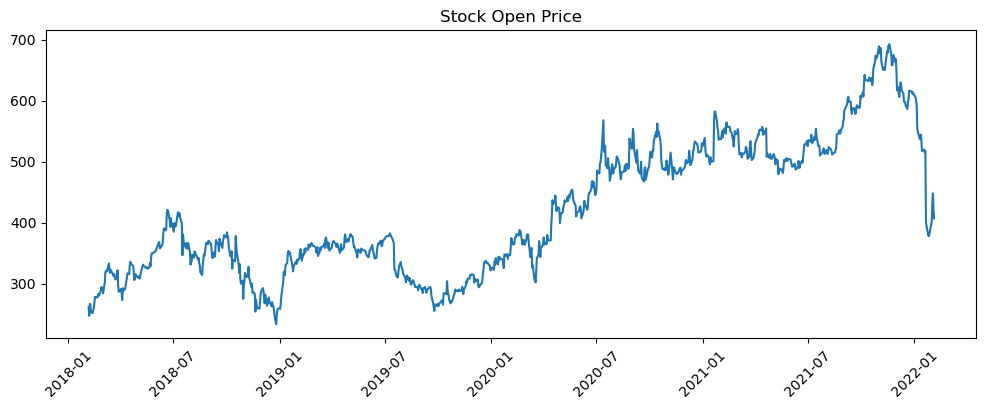

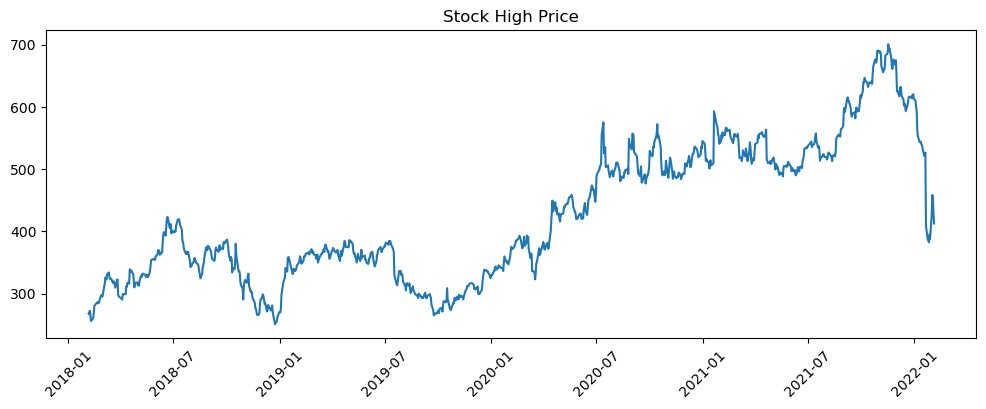

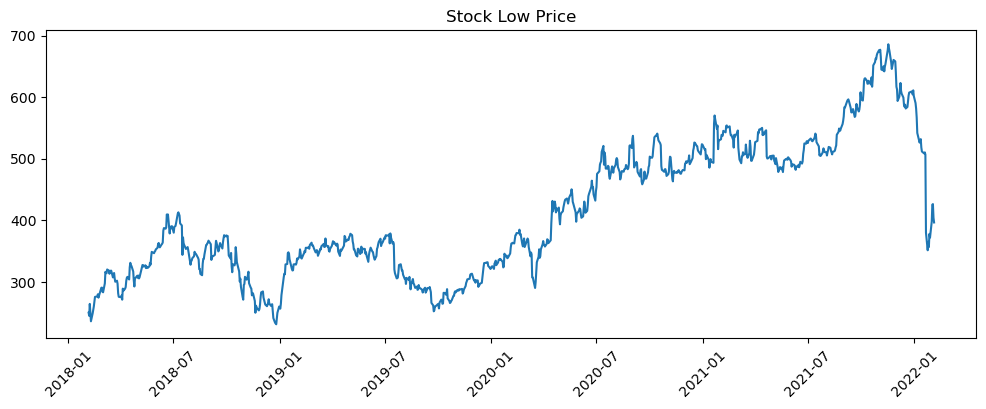

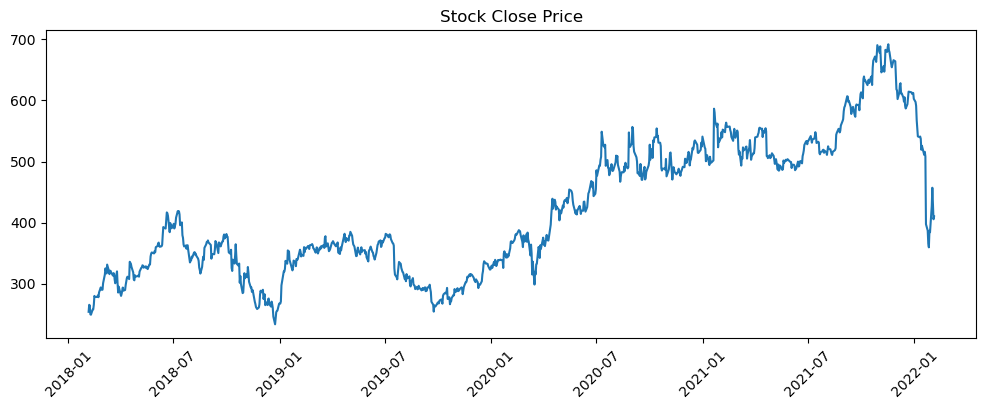

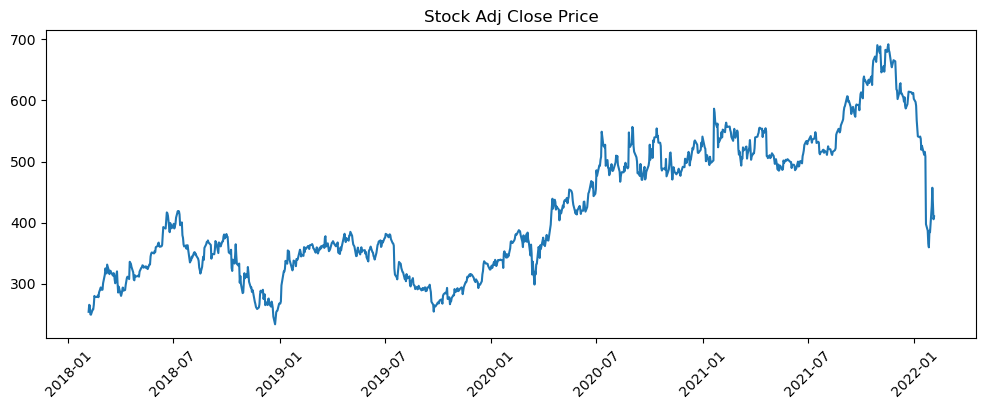

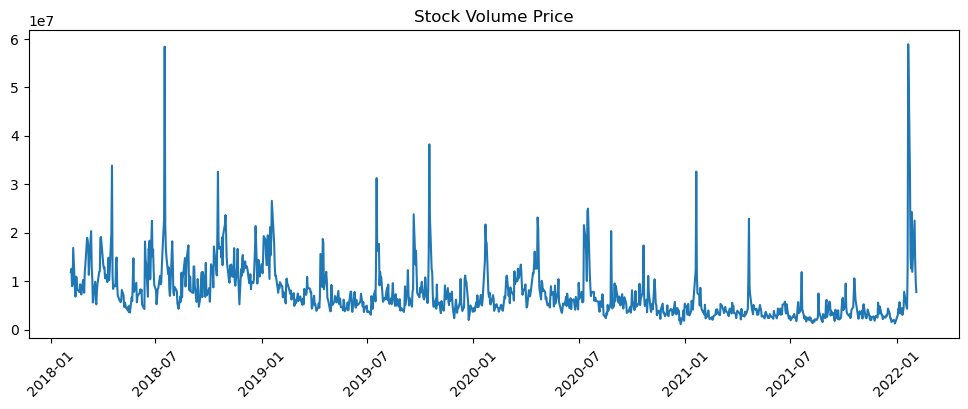

In [ ]:

for columns in data.columns:
    plt.figure(figsize=(12,4))
    plt.title(f"Stock {columns} Price")
    plt.plot(data.index,data[columns])
    plt.xticks(rotation=45)

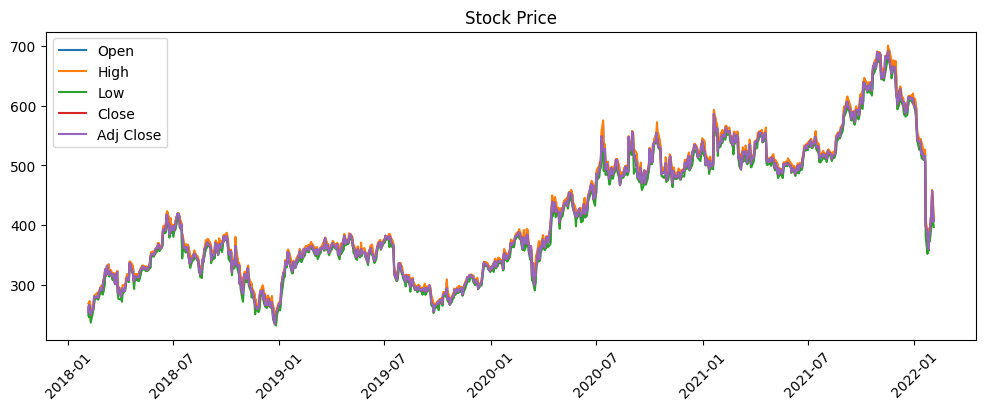

In [ ]:
plt.figure(figsize=(12,4))
plt.title("Stock Price")
for columns in data.columns:
    if(columns !='Volume'):
        plt.plot(data.index,data[columns],label=columns)
plt.xticks(rotation=45)
plt.legend()

(array([17532., 17713., 17897., 18078., 18262., 18444., 18628., 18809.,
        18993.]),
 [Text(17532.0, 0, '2018-01'),
  Text(17713.0, 0, '2018-07'),
  Text(17897.0, 0, '2019-01'),
  Text(18078.0, 0, '2019-07'),
  Text(18262.0, 0, '2020-01'),
  Text(18444.0, 0, '2020-07'),
  Text(18628.0, 0, '2021-01'),
  Text(18809.0, 0, '2021-07'),
  Text(18993.0, 0, '2022-01')])

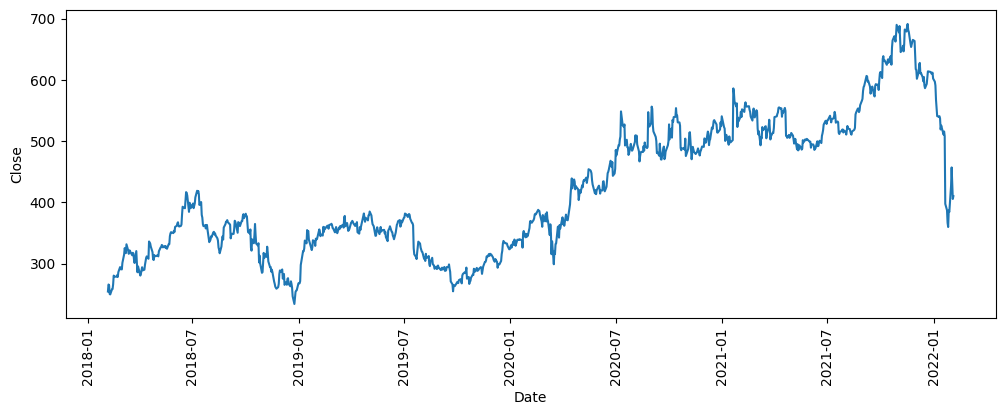

In [ ]:
plt.figure(figsize=(12,4))
sns.lineplot(x=data.Date,y=data.Close)
plt.xticks(rotation = 90)

Text(0.5, 1.0, 'Last Year NFLX Close Price')

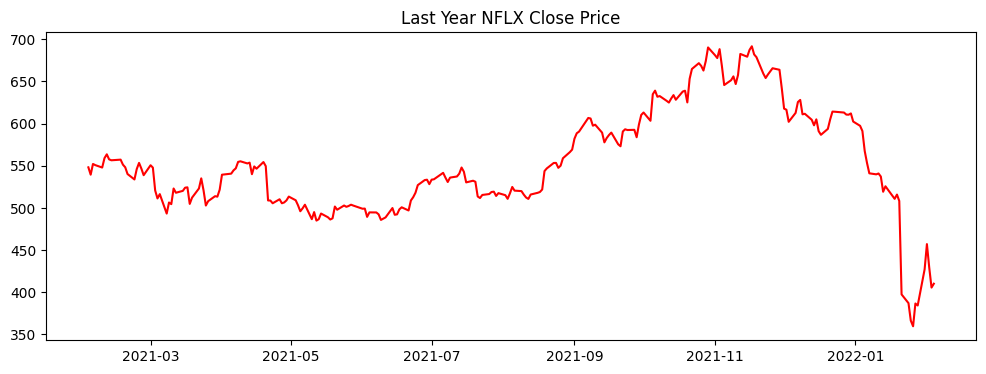

In [ ]:
#Visualizing the closing price for last year i.e. 2021
last1year_df = data[data.Date > '02-2021']

fig = plt.figure(figsize = (12,4))

plt.plot(last1year_df.Date, last1year_df['Close'], color="red")
plt.title('Last Year NFLX Close Price')

In [ ]:
pd.DataFrame(data['Close'].describe())

,Close
count,1009.000000
mean,419.000733
std,108.289999
min,233.880005
25%,331.619995
50%,378.670013
75%,509.079987
max,691.690002


<Axes: xlabel='Close', ylabel='Count'>

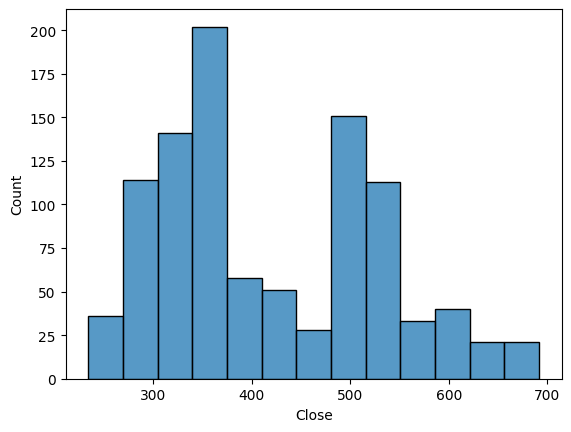

In [ ]:
#distribution of closing prices
sns.histplot(data.Close)

## Data Preprocessing

In [78]:
#scaling the closing price feature to the range (-1,1)
closing_price = data[['Close']]
scaler = MinMaxScaler(feature_range=(-1, 1))
closing_price['Close'] = scaler.fit_transform(closing_price['Close'].values.reshape(-1,1))

/var/folders/r2/88whnm8j7qz6mg_k499zyh0m0000gn/T/ipykernel_72250/1090091427.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  closing_price['Close'] = scaler.fit_transform(closing_price['Close'].values.reshape(-1,1))


In [79]:
closing_price

,Close
0,-0.910967
1,-0.860903
2,-0.865971
3,-0.929141
4,-0.931893
...,...
1004,-0.155720
1005,-0.024705
1006,-0.145497
1007,-0.249820


In [82]:
#Dividing the data into training and testing sets and specifying the window width for the analysis(sliding window approach)

def prepare_data(dataset, lookback):
    rawdata = dataset.to_numpy() # convert to numpy array
    data = []

    # create all possible sequences of length seq_len
    for i in range(len(rawdata) - lookback):
        data.append(rawdata[i: i + lookback])

    data = np.array(data);
    test_set_size = int(np.round(0.2*data.shape[0]));
    train_set_size = data.shape[0] - (test_set_size);

    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]

    x_test = data[train_set_size:,:-1]
    y_test = data[train_set_size:,-1,:]

    return [x_train, y_train, x_test, y_test]

lookback = 20
x_train, y_train, x_test, y_test = prepare_data(closing_price, lookback)

In [83]:
#converting training and testing sets to torch tensors

x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)

y_train_lstm = torch.from_numpy(y_train).type(torch.Tensor)
y_test_lstm = torch.from_numpy(y_test).type(torch.Tensor)

y_train_gru = torch.from_numpy(y_train).type(torch.Tensor)
y_test_gru = torch.from_numpy(y_test).type(torch.Tensor)

In [84]:
#saving the preprocessed data
closing_price.to_csv("price.csv")

In [72]:
#assigning the model parameters
input_dim = 1
hidden_dim = 32
num_layers = 2
output_dim = 1
num_epochs = 30

## Evaluation metrics

In [24]:
def calculate_rmse(y_true, y_pred):
    
    #calculating the Root Mean Squared Error (RMSE)
    rmse = np.sqrt(np.mean((y_true - y_pred) ** 2))
    return rmse

## Long Short Term Memory (RNN) Implementation

In [73]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    #forward propagation
    def forward(self, x):
        initial_hidden_state = torch.zeros(self.num_layers, x.size(0), self.hidden_size, requires_grad=True)
        initial_cell_state = torch.zeros(self.num_layers, x.size(0), self.hidden_size, requires_grad=True)
        lstm_output, (final_hidden_state, final_cell_state) = self.lstm(x, (initial_hidden_state.detach(), initial_cell_state.detach()))
        output = self.fc(lstm_output[:, -1, :])
        return output

In [100]:
lstm_model = LSTMModel(input_size=input_dim, hidden_size=hidden_dim, output_size=output_dim, num_layers=num_layers)
loss_function = torch.nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(lstm_model.parameters(), lr=0.01)

In [101]:
loss_history = np.zeros(num_epochs)
start_timestamp = time.time()

#Model Training
for epoch in range(num_epochs):
    predicted_train_output = lstm_model(x_train)
    current_loss = loss_function(predicted_train_output, y_train_lstm)
    print("Epoch ", epoch, "MSE: ", current_loss.item())
    loss_history[epoch] = current_loss.item()
    optimizer.zero_grad()
    current_loss.backward()
    optimizer.step()

lstm_training_duration = time.time() - start_timestamp
print("Training time: {}".format(lstm_training_duration))

Epoch  0 MSE:  0.2719247341156006
Epoch  1 MSE:  0.16375429928302765
Epoch  2 MSE:  0.11673994362354279
Epoch  3 MSE:  0.1447257697582245
Epoch  4 MSE:  0.0979078933596611
Epoch  5 MSE:  0.09623478353023529
Epoch  6 MSE:  0.0975312888622284
Epoch  7 MSE:  0.08095703274011612
Epoch  8 MSE:  0.04840356856584549
Epoch  9 MSE:  0.040874872356653214
Epoch  10 MSE:  0.042950745671987534
Epoch  11 MSE:  0.012122493237257004
Epoch  12 MSE:  0.019077492877840996
Epoch  13 MSE:  0.027858953922986984
Epoch  14 MSE:  0.016578122973442078
Epoch  15 MSE:  0.012559509836137295
Epoch  16 MSE:  0.018440917134284973
Epoch  17 MSE:  0.012368780560791492
Epoch  18 MSE:  0.006945483852177858
Epoch  19 MSE:  0.009356043301522732
Epoch  20 MSE:  0.013402603566646576
Epoch  21 MSE:  0.01437851507216692
Epoch  22 MSE:  0.012107440270483494
Epoch  23 MSE:  0.009106092154979706
Epoch  24 MSE:  0.008186220191419125
Epoch  25 MSE:  0.009473382495343685
Epoch  26 MSE:  0.009912008419632912
Epoch  27 MSE:  0.0081186

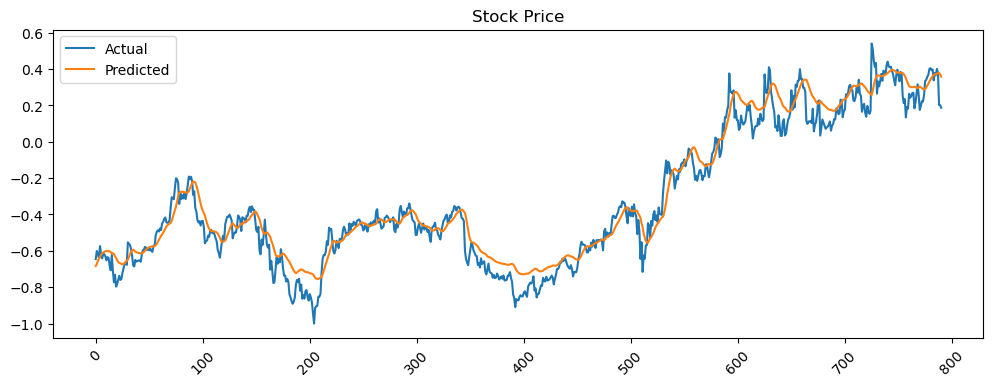

In [102]:
plt.figure(figsize=(12,4))
plt.title("Stock Price")
plt.plot(y_train_lstm,label="Actual")
y_train_pred = predicted_train_output.detach().numpy()
plt.plot(y_train_pred,label="Predicted")
plt.xticks(rotation=45)
plt.legend()

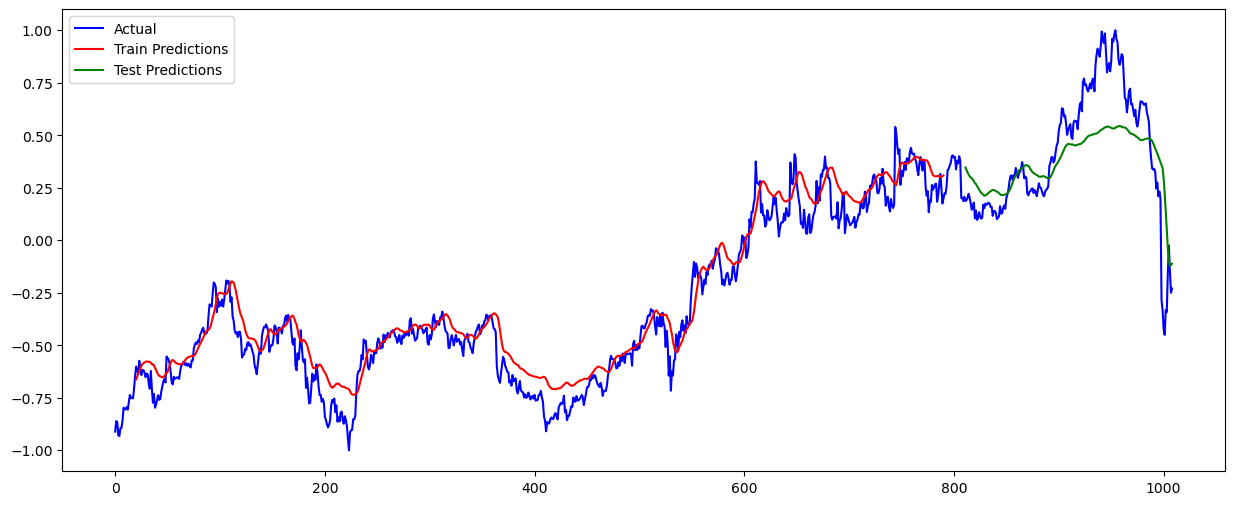

In [103]:
train_size=len(x_train)
plt.figure(figsize=(15,6))
with torch.no_grad():
    # shift train predictions for plotting
    train_plot = np.ones_like(closing_price) * np.nan
    train_plot[lookback:train_size]= lstm_model(x_train)[:train_size-lookback]
    test_plot = np.ones_like(closing_price) * np.nan
    test_plot[train_size+lookback:len(closing_price)] = lstm_model(x_test)[:]
# plot
plt.plot(price, c='b',label="Actual")
plt.plot(train_plot, c='r',label="Train Predictions")
plt.plot(test_plot, c='g',label="Test Predictions")
plt.legend(loc='upper left')


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


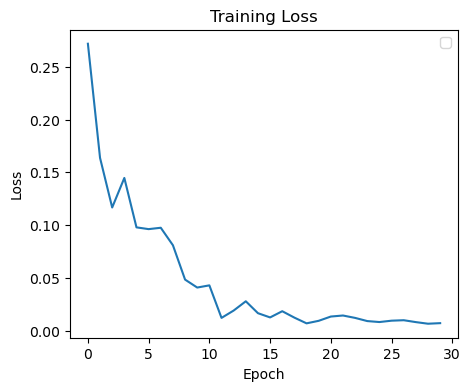

In [104]:
plt.figure(figsize=(5,4))
plt.title("Training Loss")
plt.plot(loss_history)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

In [105]:
y_test_pred=lstm_model(x_test)

In [106]:
rmse_lstm=calculate_rmse(y_test_lstm.detach().numpy(),y_test_pred.detach().numpy())
mae_lstm=mae(y_test_lstm.detach().numpy(),y_test_pred.detach().numpy())
print(f"Root Mean Square Error:{rmse_lstm}")
print(f"Mean Absolute Error:{mae_lstm}")

Root Mean Square Error:0.20111969113349915
Mean Absolute Error:0.15372002124786377


In [56]:
#saving the model
torch.save(lstm_model, 'lstm_model.pth')
torch.save(lstm_model.state_dict(), 'lstm_state_dict.pth')

## Gated Recurrent Unit (RNN) Implementation

In [92]:
class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(GRUModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        initial_hidden_state = torch.zeros(self.num_layers, x.size(0), self.hidden_size, requires_grad=True)
        output, (final_hidden_state)=self.gru(x, (initial_hidden_state.detach()))
        output=self.fc(output[:, -1, :])
        return output

In [93]:
gru_model= GRUModel(input_size=input_dim, hidden_size=hidden_dim, output_size=output_dim, num_layers=num_layers)
loss_function = torch.nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(gru_model.parameters(), lr=0.01)

In [94]:
loss_history = np.zeros(num_epochs)
start_timestamp = time.time()

#Model Training
for epoch in range(num_epochs):
    predicted_train_output = gru_model(x_train)
    current_loss = loss_function(predicted_train_output, y_train_gru)
    print("Epoch ", epoch, "MSE: ", current_loss.item())
    loss_history[epoch] = current_loss.item()
    optimizer.zero_grad()
    current_loss.backward()
    optimizer.step()

gru_training_duration = time.time() - start_timestamp
print("Training time: {}".format(gru_training_duration))

Epoch  0 MSE:  0.3064703941345215
Epoch  1 MSE:  0.14469483494758606
Epoch  2 MSE:  0.12585735321044922
Epoch  3 MSE:  0.11641418188810349
Epoch  4 MSE:  0.07453777641057968
Epoch  5 MSE:  0.05128420144319534
Epoch  6 MSE:  0.04397755116224289
Epoch  7 MSE:  0.024234646931290627
Epoch  8 MSE:  0.005359731614589691
Epoch  9 MSE:  0.031917981803417206
Epoch  10 MSE:  0.027067119255661964
Epoch  11 MSE:  0.009321813471615314
Epoch  12 MSE:  0.009674292989075184
Epoch  13 MSE:  0.013393951579928398
Epoch  14 MSE:  0.012671787291765213
Epoch  15 MSE:  0.010206508450210094
Epoch  16 MSE:  0.00961294025182724
Epoch  17 MSE:  0.011389732360839844
Epoch  18 MSE:  0.012736049480736256
Epoch  19 MSE:  0.010956286452710629
Epoch  20 MSE:  0.006901137996464968
Epoch  21 MSE:  0.0038732278626412153
Epoch  22 MSE:  0.003867618041113019
Epoch  23 MSE:  0.005745637696236372
Epoch  24 MSE:  0.006882055196911097
Epoch  25 MSE:  0.0062372018583118916
Epoch  26 MSE:  0.005105459131300449
Epoch  27 MSE:  0.

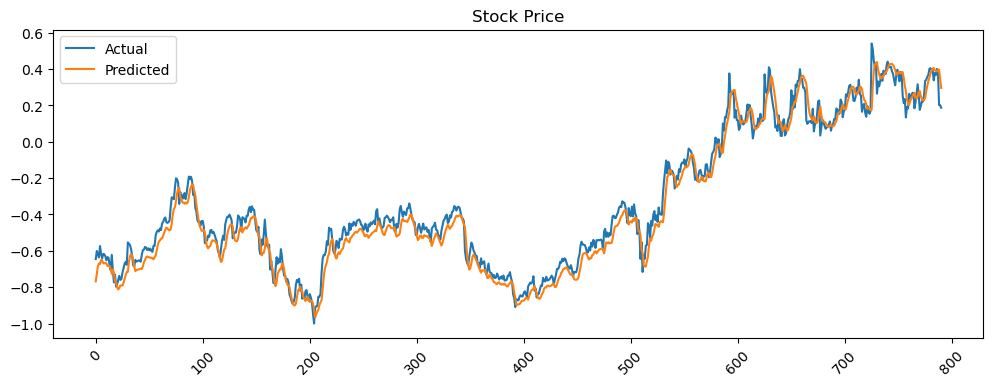

In [95]:
plt.figure(figsize=(12,4))
plt.title("Stock Price")
plt.plot(y_train_gru,label="Actual")
y_train_pred = predicted_train_output.detach().numpy()
plt.plot(y_train_pred,label="Predicted")
plt.xticks(rotation=45)
plt.legend()

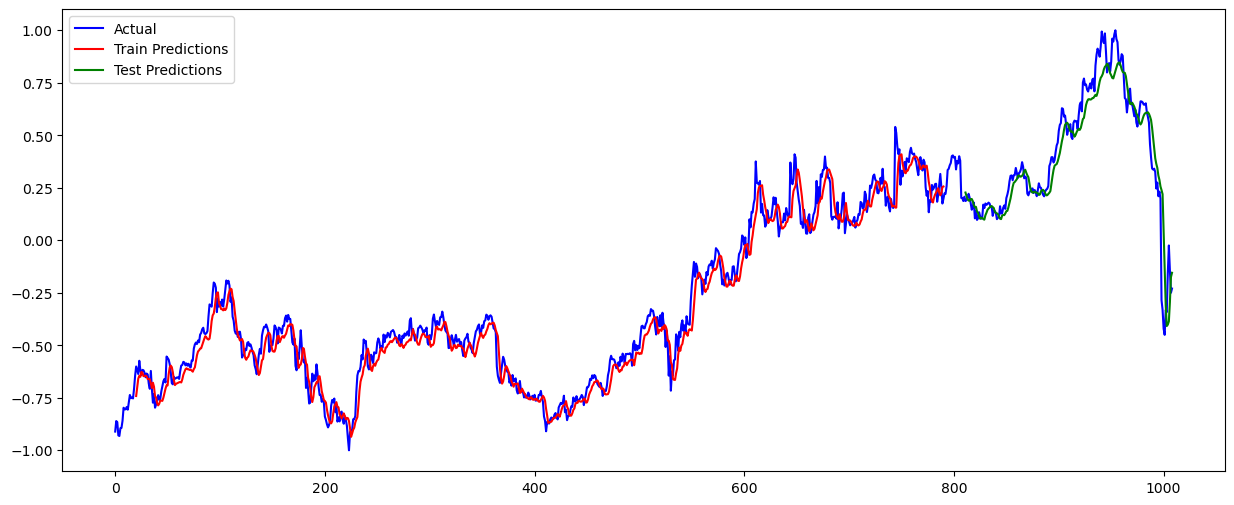

In [96]:
train_size=len(x_train)
plt.figure(figsize=(15,6))
with torch.no_grad():
    # shift train predictions for plotting
    train_plot = np.ones_like(closing_price) * np.nan
    train_plot[lookback:train_size]= gru_model(x_train)[:train_size-lookback]
    test_plot = np.ones_like(closing_price) * np.nan
    test_plot[train_size+lookback:len(closing_price)] = gru_model(x_test)[:]
# plot
plt.plot(price, c='b',label="Actual")
plt.plot(train_plot, c='r',label="Train Predictions")
plt.plot(test_plot, c='g',label="Test Predictions")
plt.legend(loc="upper left")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


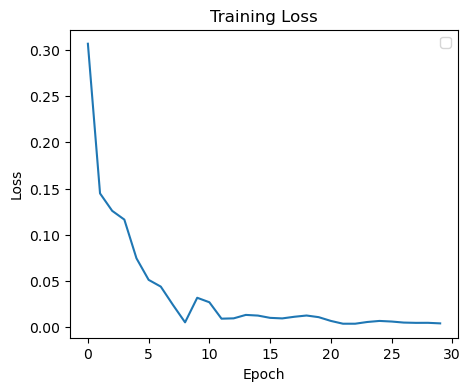

In [97]:
plt.figure(figsize=(5,4))
plt.title("Training Loss")
plt.plot(loss_history)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

In [98]:
y_test_pred = gru_model(x_test)

In [99]:
rmse_gru=calculate_rmse(y_test_gru.detach().numpy(),y_test_pred.detach().numpy())
mae_gru=mae(y_test_gru.detach().numpy(),y_test_pred.detach().numpy())
print(f"Root Mean Square Error:{rmse_gru}")
print(f"Mean Absolute Error:{mae_gru}")

Root Mean Square Error:0.08831849694252014
Mean Absolute Error:0.05993017554283142


In [55]:
#saving the model
torch.save(gru_model, 'gru_model.pth')
torch.save(gru_model.state_dict(), 'gru_state_dict.pth')

In [107]:
scores={"Model":['LSTM','GRU'],"RMSE":[rmse_lstm,rmse_gru],"MAE":[mae_lstm,mae_gru],"Training Time":[lstm_training_duration,gru_training_duration]}
scores=pd.DataFrame(scores)
scores

,Model,RMSE,MAE,Training Time
0,LSTM,0.201120,0.15372,17.834628
1,GRU,0.088318,0.05993,13.989397
